<a href="https://colab.research.google.com/github/aarmentamna/machine_learning_advance/blob/main/TC5033_Activity3b_42.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Maestría en Inteligencia Artificial Aplicada**
### **Curso: ADVANCED MACHINE LEARNING METHODS**
## Tecnológico de Monterrey
### Dr. José Antonio Cantoral Ceballos

## Activity Week 7
### Text Classification using RNNs and AG_NEWS dataset in PyTorch

*TEAM MEMBERS:*

*   Roberto Romero Vielma - A00822314
*   José Javier Granados Hernández - A00556717
*   Aquiles Yonatan Armenta Hernandez - A01793252
*   Alan Avelino Fernández Juárez - A00989308

## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy function (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [1]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [2]:
!pip install scikit-plot
!pip install portalocker>=2.0.0

In [3]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

In [4]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [5]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [6]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [7]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [8]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [9]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [10]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [11]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [12]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [13]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [15]:
EMBEDDING_SIZE = 100
NEURONS = 64
LAYERS = 2
NUM_CLASSES = 4

In [16]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        # Define the recurrent layer (you can choose between nn.GRU() or nn.LSTM())
        self.rnn = nn.GRU(input_size=embed_size, hidden_size=hidden, num_layers=layers, batch_first=True)
        # or, for LSTM:
        # self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden, num_layers=layers, batch_first=True)

        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        embedded = self.embedding_layer(x)

        # Pass the embedded input through the RNN layer
        output, _ = self.rnn(embedded)

        # Get the output of the last time step
        output = output[:, -1, :]

        # Apply the classifier layer
        output = self.fc(output)

        return output



In [17]:
def accuracy(model, loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for data in loader:
            inputs, labels = data
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    accuracy = (correct / total) * 100
    return accuracy

In [18]:
def train(model, optimizer, train_loader, val_loader, epochs=100):
    # Define the loss function (criterion)
    criterion = nn.CrossEntropyLoss()

    # Track training and validation loss for plotting
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.long().to(device)  # Convert labels to 'Long'

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Evaluate the model on the validation set
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():  # Disable gradient computation
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.long().to(device)  # Convert labels to 'Long'
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{epochs}] - Training Loss: {train_losses[-1]:.4f} - Validation Loss: {val_losses[-1]:.4f}")

In [19]:
epochs = 20
lr = 0.001
# instantiate model
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES).to(device)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)


In [20]:
train(rnn_model, optimizer=optimiser, train_loader=train_loader, val_loader=val_loader, epochs=epochs)

Epoch [1/20] - Training Loss: 0.7442 - Validation Loss: 0.4063
Epoch [2/20] - Training Loss: 0.3160 - Validation Loss: 0.3046
Epoch [3/20] - Training Loss: 0.2348 - Validation Loss: 0.2835
Epoch [4/20] - Training Loss: 0.1851 - Validation Loss: 0.2728
Epoch [5/20] - Training Loss: 0.1468 - Validation Loss: 0.2765
Epoch [6/20] - Training Loss: 0.1167 - Validation Loss: 0.2990
Epoch [7/20] - Training Loss: 0.0904 - Validation Loss: 0.3244
Epoch [8/20] - Training Loss: 0.0715 - Validation Loss: 0.3376
Epoch [9/20] - Training Loss: 0.0571 - Validation Loss: 0.3735
Epoch [10/20] - Training Loss: 0.0459 - Validation Loss: 0.3965
Epoch [11/20] - Training Loss: 0.0368 - Validation Loss: 0.4149
Epoch [12/20] - Training Loss: 0.0293 - Validation Loss: 0.4902
Epoch [13/20] - Training Loss: 0.0261 - Validation Loss: 0.4559
Epoch [14/20] - Training Loss: 0.0212 - Validation Loss: 0.5144
Epoch [15/20] - Training Loss: 0.0183 - Validation Loss: 0.5186
Epoch [16/20] - Training Loss: 0.0173 - Validatio

In [21]:
print(f'{accuracy(rnn_model, test_loader):.4f}')

89.7500


In [22]:
def sample_text(model, loader, tokenizer, sample_text):
    model.eval()  # Set the model to evaluation mode

    # Tokenize the sample text and convert it to a tensor
    tokenized_sample = torch.tensor(vocab(tokenizer(sample_text)), device=device)

    # Perform text classification using the model
    with torch.no_grad():
        output = model(tokenized_sample.unsqueeze(0))

        # Get the predicted class
        _, predicted_class = torch.max(output, 1)

    return labels[predicted_class.item()]

In [23]:
sample_text(rnn_model, test_loader, tokeniser, 'Soccer')

'Sports'

In [24]:
def create_confusion_matrix(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            output = model(inputs)
            _, predicted = torch.max(output, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Create the confusion matrix using scikit-learn
    cm = skplt.metrics.plot_confusion_matrix(true_labels, predicted_labels, figsize=(8, 6))

    return cm

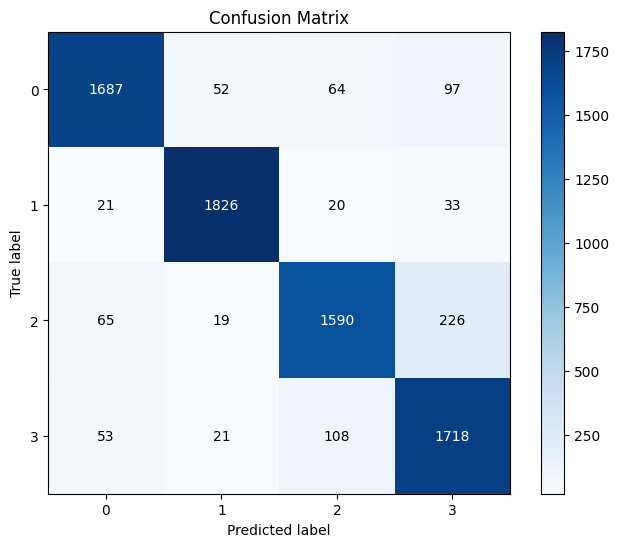

In [25]:
# Assuming you have a test_loader for classification
confusion_matrix = create_confusion_matrix(rnn_model, test_loader)